In [1]:
import __init__
from __init__ import DATA_PATH
from __init__ import PACKAGE_PATH
from dce import DCE
from cluster import Cluster
from descriptor import rdkitDescriptors
import utilities
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from keras import Model
%matplotlib inline

Using TensorFlow backend.


(array([756.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 307.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

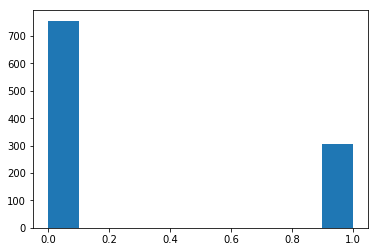

In [2]:
df = pd.read_csv(os.path.join(DATA_PATH,'BOD_RDKit_Descriptors_1063.csv'))
df['cleaned_bod'] = utilities.clean_out_of_bound(df['value (% BOD)'])

df['bi_class_partition'] = utilities.divide_classes(df['cleaned_bod'], [60])
true_label_biclass = df['bi_class_partition'].values
plt.hist(df['bi_class_partition']) # biclass

## 1. Using fingerprint

In [3]:
fps = rdkitDescriptors.batch_compute_rdkit_fingerprints(df['SMILES'])
len(fps[0])

2048

* Train test split 75-25

In [4]:
from sklearn.model_selection import train_test_split

In [86]:
X_train, X_test, y_train, y_test = train_test_split(fps, true_label_biclass, test_size=0.25, random_state=42)

## 1.1 raw fingerprint for supervised classfication

In [11]:
from sklearn.ensemble import RandomForestClassifier

In [30]:
clf = RandomForestClassifier(n_estimators=500, max_depth=5,random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [31]:
y_pred=clf.predict(X_test)

Text(0.5, 1.0, 'Testing raw fingerprint, predicted label')

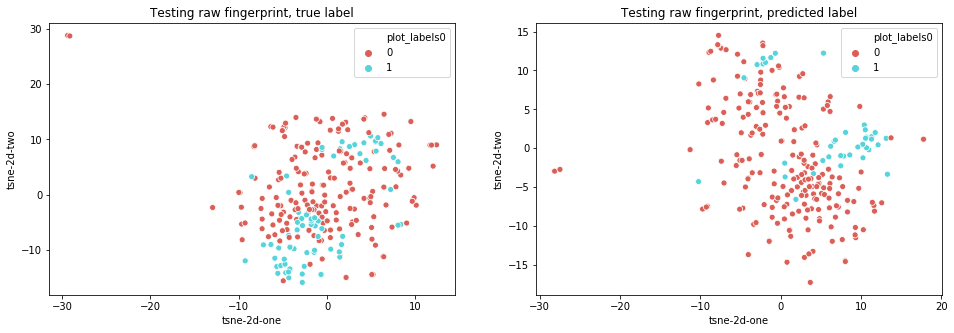

In [32]:
fig, ax=plt.subplots(1,2,figsize=(16,5))
utilities.tsne_2d_visulization(X_test, y_test, ax=ax[0], verbose=0)
utilities.tsne_2d_visulization(X_test, y_pred, ax=ax[1], verbose=0)
ax[0].set_title('Testing raw fingerprint, true label')
ax[1].set_title('Testing raw fingerprint, predicted label')

* Since this is about classifying to the correct class, we need to use accuracy score as metrics 

In [33]:
from sklearn.metrics import accuracy_score

In [36]:
accuracy_score(y_test, y_pred) # not bad

0.8157894736842105

In [50]:
def classifier_losses(y_true, y_pred,normalize = True):
    loss_dict = {}
    loss_dict['hamming_loss'] = hamming_loss(y_true, y_pred)
    loss_dict['hinge_loss'] = hinge_loss(y_true, y_pred)
    return loss_dict

In [51]:
classifier_losses(y_test, y_pred)

{'hamming_loss': 0.18421052631578946, 'hinge_loss': 0.8947368421052632}

In [49]:
log_loss(y_test, clf.predict_proba(X_test), normalize=True, labels=y_test)

0.43900246248660757

* Fewer estimators just as reference to latent space classification

In [87]:
clf2 = RandomForestClassifier(n_estimators=100, max_depth=5,random_state=42)
clf2.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [88]:
y_pred2=clf2.predict(X_test)

In [92]:
accuracy_score(y_test,y_pred2) 

0.8195488721804511

In [90]:
classifier_losses(y_test, y_pred2)

{'hamming_loss': 0.18045112781954886, 'hinge_loss': 0.8909774436090225}

In [93]:
log_loss(y_test, clf2.predict_proba(X_test), normalize=True, labels=y_test)

0.4404682883230851

## 1.2 autoencoded fingerprint (extract the hidden layer) for supervised classfication

In [59]:
from dimreducer import DeepAutoEncoder as DAE

In [60]:
dims =[2048,1028,128]
autoencoder = DAE(dims, act='relu')
autoencoder.build_model(norm=False)
history = autoencoder.train_model(fps, norm_feature=False, epochs=100)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
1063/1063 [==============================] - ETA: 2s - loss: 0.094 - ETA: 1s - loss: 0.085 - ETA: 0s - loss: 0.081 - ETA: 0s - loss: 0.080 - 1s 1ms/step - loss: 0.0811
Epoch 2/100
1063/1063 [==============================] - ETA: 0s - loss: 0.076 - ETA: 0s - loss: 0.072 - ETA: 0s - loss: 0.072 - ETA: 0s - loss: 0.071 - 1s 640us/step - loss: 0.0715
Epoch 3/100
1063/1063 [==============================] - ETA: 0s - loss: 0.067 - ETA: 0s - loss: 0.063 - ETA: 0s - loss: 0.065 - ETA: 0s - loss: 0.065 - 1s 658us/step - loss: 0.0649
Epoch 4/100
1063/1063 [==============================] - ETA: 0s - loss: 0.060 - ETA: 0s - loss: 0.060 - ETA: 0s - loss: 0.060 - ETA: 0s - loss: 0.059 - 1s 655us/step - loss: 0.0585
Epoch 5/100
1063/1063 [==============================] - ETA: 0s - loss: 0.056 - ETA: 0s - loss: 0.054 - ETA: 0s - loss: 0.054 - ETA: 0s - loss: 0.053 - 1

1063/1063 [==============================] - ETA: 0s - loss: 0.010 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.010 - ETA: 0s - loss: 0.010 - 1s 619us/step - loss: 0.0105
Epoch 43/100
1063/1063 [==============================] - ETA: 0s - loss: 0.010 - ETA: 0s - loss: 0.010 - ETA: 0s - loss: 0.010 - ETA: 0s - loss: 0.010 - 1s 690us/step - loss: 0.0105
Epoch 44/100
1063/1063 [==============================] - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.010 - ETA: 0s - loss: 0.010 - 1s 697us/step - loss: 0.0106
Epoch 45/100
1063/1063 [==============================] - ETA: 0s - loss: 0.010 - ETA: 0s - loss: 0.010 - ETA: 0s - loss: 0.010 - ETA: 0s - loss: 0.010 - 1s 710us/step - loss: 0.0107
Epoch 46/100
1063/1063 [==============================] - ETA: 0s - loss: 0.010 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.010 - 1s 733us/step - loss: 0.0107
Epoch 47/100
1063/1063 [==============================] - ETA: 0s - loss: 0.009 - ETA: 0s - loss: 

Epoch 87/100
1063/1063 [==============================] - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.008 - 1s 687us/step - loss: 0.0088
Epoch 88/100
1063/1063 [==============================] - ETA: 0s - loss: 0.009 - ETA: 0s - loss: 0.009 - ETA: 0s - loss: 0.009 - ETA: 0s - loss: 0.008 - 1s 678us/step - loss: 0.0088
Epoch 89/100
1063/1063 [==============================] - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.009 - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.008 - 1s 677us/step - loss: 0.0088
Epoch 90/100
1063/1063 [==============================] - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.009 - ETA: 0s - loss: 0.009 - ETA: 0s - loss: 0.008 - 1s 679us/step - loss: 0.0088
Epoch 91/100
1063/1063 [==============================] - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.008 - 1s 709us/step - loss: 0.0087
Epoch 92/100
1063/1063 [==============================] - ETA: 0s - loss: 0.008 - ETA

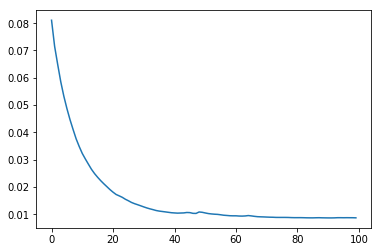

In [61]:
plt.plot(history.history['loss'])

In [77]:
encoder = Model(inputs=autoencoder.model.input, 
                outputs=autoencoder.model.get_layer(name='embedding_layer').output)
hidden_feat = encoder.predict(fps)
X_train_hid, X_test_hid, y_train_ae, y_test_ae = train_test_split(hidden_feat, true_label_biclass, test_size=0.25, random_state=42)
clf_ae = RandomForestClassifier(n_estimators=100, max_depth=5,random_state=42) # n_esimators is reduced because dimension is reduced
clf_ae.fit(X_train_hid, y_train_ae)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [78]:
y_pred_ae=clf_ae.predict(X_test_hid)

Text(0.5, 1.0, 'Testing autoencoded fingerprint, predicted label')

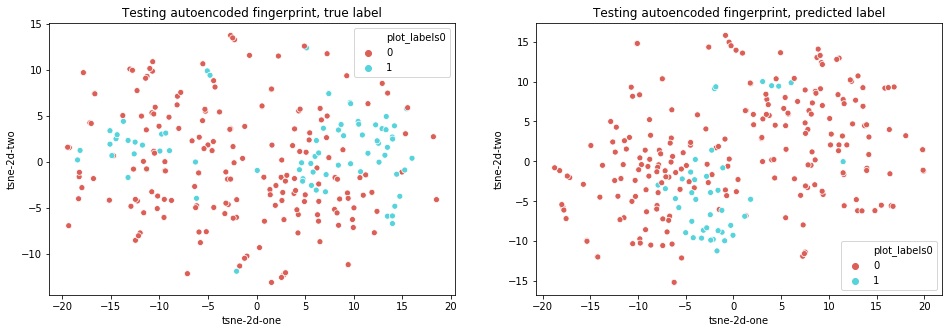

In [79]:
fig, ax=plt.subplots(1,2,figsize=(16,5))
utilities.tsne_2d_visulization(X_test_hid, y_test_ae, ax=ax[0], verbose=0)
utilities.tsne_2d_visulization(X_test_hid, y_pred_ae, ax=ax[1], verbose=0)
ax[0].set_title('Testing autoencoded fingerprint, true label')
ax[1].set_title('Testing autoencoded fingerprint, predicted label')

In [80]:
accuracy_score(y_test_ae, y_pred_ae) # score is slightly better

0.8233082706766918

In [82]:
classifier_losses(y_test_ae, y_pred_ae) # loss is smaller

{'hamming_loss': 0.17669172932330826, 'hinge_loss': 0.8872180451127819}

In [85]:
log_loss(y_test_ae, clf_ae.predict_proba(X_test_hid), normalize=True, labels=y_test_ae) # loss is smaller

0.40669451696920583

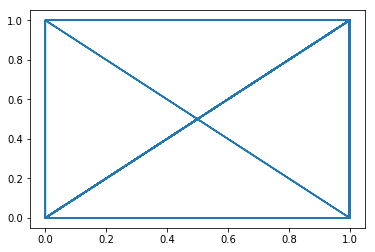